Notebook for the analysis in Lutsko and Popp (2019). This notebook produces 3 figures:<br/>
    -pdfs of EBM parameters + TCR sensitivity to uncertainty in each parameter (Part 1)<br/>
    -ratio of TCR's sensitivity to each parameter in the EBM (except for Forcing), divided by TCR's sensitivity to uncertainty in the forcing. (Part 1)<br/>
    -Test of sensitivity of "tuned" climate sensitivity to assumptions made about the historical forcing (Part 2)

In [338]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares
import scipy.stats

# Part 1

## Fit the EBM

## Functions for fitting without epsilon

In [237]:
def func( t, a, tau_s):
    return np.log(a) - t / tau_s

def fit_data( t1, r1):
    #Do Geoffroy fitting to get EBM parameters
    
    #Get F and \lambda
    regr = LinearRegression()
    # Train the model using the training sets
    regr.fit(t1[:, np.newaxis], r1[:, np.newaxis])
    lam = -regr.coef_
    F = regr.intercept_ 
    
    t_eq = F / lam
    
    #Now get as and \taus
    x = np.log( 1. - t1[30:] / t_eq) #Fit years 30-150
    t = np.arange(30, 150, 1)
    x = x[0]
    
    init_vals = [1, 150.]  # initial guesses for a and tau_s
    best_vals, covar = curve_fit(func, t, x, p0=init_vals)
    a_s = best_vals[0]
    tau_s = best_vals[1]

    a_f = 1. - a_s
        
    #get \tau_f from first 10 years
    t = np.arange(1, 11, 1)
    tau_f = np.mean( t / (np.log(a_f) - np.log(1. - t1[:10] / t_eq - a_s * np.exp( -t / tau_s) )) )
    
    c = lam/(a_f / tau_f + a_s / tau_s)
    c0 = lam * (a_f * tau_f + a_s * tau_s) - c
    gamma = c0 / (a_f * tau_s + a_s * tau_f)

    return F, lam, c, c0, gamma, tau_s, tau_f, a_f, a_s

## Functions for adjusting for epsilon

In [238]:
def fit_data_2( t1, r1, F, lam, eps):
    #Fit with epsilon
    
    t_eq = F / lam
    #Get as and \taus
    x = np.log( 1. - t1[30:] / t_eq) #Fit years 30-150
    t = np.arange(30, 150, 1)
    x = x[0]
    
    init_vals = [1, 218.]  # initial guesses for a and tau_s
    best_vals, covar = curve_fit(func, t, x, p0=init_vals)
    a_s = best_vals[0]
    tau_s = best_vals[1]

    a_f = 1. - a_s
    
    #get \tau_f from first 10 years
    t = np.arange(1, 11, 1)
    tau_f = np.mean( t / (np.log(a_f) - np.log(1. - t1[:10] / t_eq - a_s * np.exp( -t / tau_s) )) )
    
    c = lam/(a_f / tau_f + a_s / tau_s) 
    c0 = (lam * (a_f * tau_f + a_s * tau_s) - c) / eps
    gamma = c0 / (a_f * tau_s + a_s * tau_f) / eps

    return c, c0, gamma

def calc_params( lam, gam, eps, c, c0):
    #Calculate EBM parameters
    
    b = (lam + gam * eps) / c + gam / c0
    bs = (lam + gam * eps) / c - gam / c0
    
    delta = b **2 - 4. * lam * gam / (c * c0)
    
    tau_f = c * c0 / (2. * lam * gam) * (b - np.sqrt( delta))
    tau_s = c * c0 / (2. * lam * gam) * (b + np.sqrt( delta))
 
    phi_f = c / (2. * eps * gam) * (bs - np.sqrt( delta))
    phi_s = c / (2. * eps * gam) * (bs + np.sqrt( delta))
    
    a_f = phi_s * tau_f * lam / (c * (phi_s - phi_f))
    a_s = -phi_f * tau_s * lam / (c * (phi_s - phi_f))
    
    return tau_f, tau_s, a_f, a_s, phi_f, phi_s

def adjust( t1, r1, F, lam, gamma, c, c0):
    #Adjust F, lambda and epsilon
    init_vals = [F, lam, 1.]
    t = np.arange( 1, len( t1) + 1, 1)
    
    def EBM_func( x):
        #minimize r1 - (F - \lambda T - (epsilon - 1) * H)
        return r1 - x[0] + x[1] * t1 + (x[2] - 1.) * H[0]
    
    for i in range( 10 ):
    
        tau_f, tau_s, a_f, a_s, phi_f, phi_s = calc_params( init_vals[1], gamma, init_vals[2], c, c0)
        T1 = init_vals[0] / init_vals[1] * (a_f * (1. - np.exp( -t / tau_f)) + a_s * (1. - np.exp( -t / tau_s))) 
        T2 = init_vals[0] / init_vals[1] * (phi_f * a_f * (1. - np.exp( -t / tau_f)) + phi_s * a_s * (1. - np.exp( -t / tau_s)))

        H = gamma * (T1 - T2)
        T = np.array( [t1[:], t1[:]] )
        best_vals = least_squares( EBM_func, x0 = init_vals)
        init_vals[:] = best_vals.x
        
        #c, c0, gamma = fit_data_2( t1, r1, init_vals[0], init_vals[1], init_vals[2])

    return init_vals[0], init_vals[1], gamma, init_vals[2], c, c0 #F, lambda, gamma, epsilon, c, c0
        

## Fit the CMIP5 runs

In [255]:
mods = ["GFDL-CM3", "GFDL-ESM2G", "GFDL-ESM2M", "CCSM4", "IPSL-CM5A-LR", "HadGEM2-ES", 
"GISS-E2-R", "MPI-ESM-LR", "MIROC5", "CSIRO-Mk3-6-0", "INM-CM4", "FGOALS-s2", "BCC-CSM1-1", 
"CNRM-CM5", "BNU-ESM", "MRI-CGCM3", "NorESM1-M", "CanESM2" ]
v = 6
l = len(mods)
var = np.zeros( ( v, l ))
opts = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
for i in opts:
    t1 = np.load( "CMIP5_data/" + mods[i] + "_temp.dat" )
    r1 = np.load( "CMIP5_data/" + mods[i] + "_net_TOA.dat" )
    #First fitting:
    F, lam, c, c0, gamma, tau_s, tau_f, a_f, a_s = fit_data( t1, r1 )
    #Now adjust
    var[:, i] = adjust( t1, r1, F, lam, gamma, c, c0)

var[0] /= 2. #Convert to 2xCO2

var = np.ma.masked_where( var == 0, var)

/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


# Plot Results

[[1.00000000e+00 4.54563124e-01 6.34543158e-01 6.25419581e-01
  6.04907785e-01 4.65252656e-02]
 [4.54563124e-01 1.00000000e+00 4.84732651e-01 1.29428976e-01
  4.87291405e-01 3.10329064e-01]
 [6.34543158e-01 4.84732651e-01 1.00000000e+00 6.70753094e-01
  4.16144588e-01 5.91429773e-02]
 [6.25419581e-01 1.29428976e-01 6.70753094e-01 1.00000000e+00
  3.76716350e-01 1.52807115e-04]
 [6.04907785e-01 4.87291405e-01 4.16144588e-01 3.76716350e-01
  1.00000000e+00 2.17126554e-01]
 [4.65252656e-02 3.10329064e-01 5.91429773e-02 1.52807115e-04
  2.17126554e-01 1.00000000e+00]]


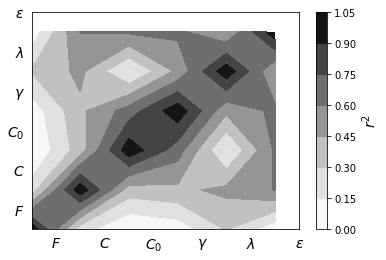

In [256]:
#Take mean and std
var_mean = np.mean( var, axis = 1 )
var_std = np.std( np.ma.masked_where( var > 200., var ), axis = 1) #Note the outlier

#Make contour plot of r^2 values between the parameters, also print correlations
corrs = np.zeros( ( v, v ) )
for i in range( v ):
    for j in range( v ):
        corrs[i, j] = np.corrcoef( var[i], var[j] )[0, 1] ** 2

print corrs
ax = plt.subplot(1, 1, 1)
plt.contourf( corrs[::-1, ::-1],  cmap = plt.cm.Greys )
cb = plt.colorbar()
cb.set_label("$r^2$", fontsize = 14)

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ["$F$", "$C$", "$C_0$", "$\\gamma$", "$\\lambda$", "$\\epsilon$"], fontsize = 14)
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ["$F$", "$C$", "$C_0$", "$\\gamma$", "$\\lambda$", "$\\epsilon$"], fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="off", top = "off", labelbottom = "on")                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="off", right="off", labelleft="on")        

plt.show()


## Now do EBM integrations<br>

The easiest way to do this is to vary each parameter by \pm 1std and \pm 2std, but then can't make the box and whisker plots. So instead do the equivalent thing and run Monte-Carlo simulations, varying one parameter at a time

In [284]:
t = 141
tt = 10000
mean_T = np.zeros( ( ( v, tt, t ) ) )

def forcing( co2, f ):
	#Convert CO2 value to forcing
	return (co2 - 1.) * f 

def T1( c, f, l, g, t_1, t_2, eps ):
	#RHS of equation for T_1
	return 1. / c * (f - l * t_1 - eps * g * (t_1 - t_2) )

def T2( c, g, t_1, t_2 ):
	#RHS of equation for T_2
	return 1. / c * g * (t_1 - t_2)

for k in range( v ):
    
    print "Doing: ", k

    for j in range( tt ):

        Co2 = np.ones( t )
        For = np.zeros( t )
        T_1 = np.zeros( t )
        T_2 = np.zeros( t )

        v_x = np.random.normal( loc = var_mean[k], scale = var_std[k] )
            
        for i in range( 1, t ):
            Co2[i] = Co2[i - 1] * 1.01
            if k == 0:
                For[i] = forcing(Co2[i], v_x)
            else:
                For[i] = forcing(Co2[i], var_mean[0])
            
            if k == 1:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], v_x, var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])
            elif k == 2:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], v_x, T_1[i - 1], T_2[i - 1], var_mean[3])
            elif k == 3:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], v_x)
            elif k == 4:
                T_1[i] = T_1[i - 1] + T1( v_x, For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])
            else:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])

            if k == 5:
                T_2[i] = T_2[i - 1] + T2( v_x, var_mean[2], T_1[i - 1], T_2[i - 1])
            elif k == 2:
                T_2[i] = T_2[i - 1] + T2( var_mean[5], v_x, T_1[i - 1], T_2[i - 1])
            else:
                T_2[i] = T_2[i - 1] + T2( var_mean[5], var_mean[2], T_1[i - 1], T_2[i - 1])

        mean_T[k, j] = T_1[:]

Doing:  0
Doing:  1
Doing:  2
Doing:  3
Doing:  4
Doing:  5


In [281]:
#Repeat with all the parameters having the same relative uncertainty
mean_T2 = np.zeros( ( ( v, tt, t ) ) )

for k in range( v ):
    
    print "Doing: ", k

    for j in range( tt ):

        Co2 = np.ones( t )
        For = np.zeros( t )
        T_1 = np.zeros( t )
        T_2 = np.zeros( t )

        v_x = np.random.normal( loc = var_mean[k], scale = var_std[1] * var_mean[k] / var_mean[1] )
            
        for i in range( 1, t ):
            Co2[i] = Co2[i - 1] * 1.01
            if k == 0:
                For[i] = forcing(Co2[i], v_x)
            else:
                For[i] = forcing(Co2[i], var_mean[0])
            
            if k == 1:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], v_x, var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])
            elif k == 2:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], v_x, T_1[i - 1], T_2[i - 1], var_mean[3])
            elif k == 3:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], v_x)
            elif k == 4:
                T_1[i] = T_1[i - 1] + T1( v_x, For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])
            else:
                T_1[i] = T_1[i - 1] + T1( var_mean[4], For[i], var_mean[1], var_mean[2], T_1[i - 1], T_2[i - 1], var_mean[3])

            if k == 5:
                T_2[i] = T_2[i - 1] + T2( v_x, var_mean[2], T_1[i - 1], T_2[i - 1])
            elif k == 2:
                T_2[i] = T_2[i - 1] + T2( var_mean[5], v_x, T_1[i - 1], T_2[i - 1])
            else:
                T_2[i] = T_2[i - 1] + T2( var_mean[5], var_mean[2], T_1[i - 1], T_2[i - 1])

        mean_T2[k, j] = T_1[:]
    

Doing:  0
Doing:  1
Doing:  2
Doing:  3
Doing:  4
Doing:  5


In [271]:
#Calculate TCR's using the raw model values
mod_vals = np.zeros( l )
for j in range( l ):
	Co2 = np.ones( 70 )
	For = np.zeros( 70 )
	T_1 = np.zeros( 70 )
	T_2 = np.zeros( 70 )

	for i in range( 1, 70 ):
		Co2[i] = Co2[i - 1] * 1.01
		For[i] = (Co2[i] - 1.) * var[0, j] 
		
		T_1[i] = T_1[i - 1] + 1. / var[4, j] * ( For[i - 1] - var[1, j] * T_1[i - 1] - var[2, j] * var[3, j] * (T_1[i - 1] - T_2[i - 1]) )
		T_2[i] = T_2[i - 1] + 1. / var[5, j] * ( var[2, j] * (T_1[i - 1] - T_2[i - 1]) )
	mod_vals[j] = T_1[i]

/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Warning: converting a masked element to nan.
  


/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


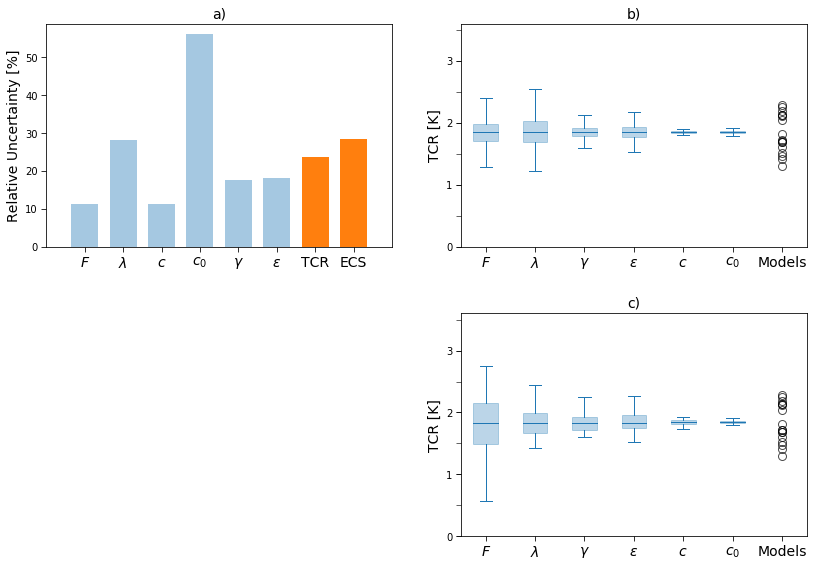

In [285]:
#Plot!
fig = plt.figure( figsize = (12, 8) )
plt.subplots_adjust(left = 0.1, right = 0.98, bottom = 0.06, top = 0.95, hspace = 0.3)

cs = [(31 / 255., 119 / 255., 180 / 255.), (44. / 255., 160 / 255., 44 / 255.), (214 / 255., 39 / 255., 40 / 255.), (255 / 255., 127 / 255., 14 / 255.) ]

#TCR and ECS values calculated elsewhere
TCR =  [2., 1.1, 1.3, 1.8, 2., 2.5, 1.5, 2., 1.5, 1.8, 1.3, 2.4, 1.7, 2.1, 2.6, 1.6, 1.4, 2.4]
ECS = [ 2.5, 3., 4.25, 5.5, 2.25, 3.9, 2.8, 5.1, 1.9, 4.5, 2.9, 3.2, 3.9, 2.7, 3.25, 3.9, 4.1, 2.31]
data = [np.std( var[0] ) / np.mean( var[0] ), np.std( 1. / var[1] ) / np.mean( 1. / var[1] ), np.std( var[4] ) / np.mean( var[4] ), np.std( var[5] ) / np.mean( var[5] ), np.std( var[2] ) / np.mean( var[2] ), np.std( var[3] ) / np.mean( var[3] ) ]

k = [1., 2., 3., 4., 5., 6.]
k2 = 7.
k3 = 8.

ax = plt.subplot(2, 2, 1)
plt.title( "a)", fontsize = 14)
plt.bar( k, np.array(data) * 100., width = 0.7, color = cs[0], edgecolor = cs[0], linewidth = 0., alpha = 0.4 )
plt.bar( k3, np.std( ECS ) / np.mean( ECS ) * 100., width = 0.7, color = cs[3], edgecolor = cs[3], linewidth = 0.)#, alpha = 0.5 )
plt.bar( k2, np.std( TCR ) / np.mean( TCR ) * 100., width = 0.7, color = cs[3], edgecolor = cs[3], linewidth = 0.)#, alpha = 0.5 )

plt.ylabel("Relative Uncertainty [%]", fontsize = 14)

plt.xticks([1., 2., 3., 4., 5., 6., 7., 8.], ["$F$", "$\\lambda$", "$c$", "$c_0$", "$\\gamma$", "$\\epsilon$", "TCR", "ECS"], fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

plt.xlim([0., 9.])

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(.5)

data = [mean_T[0, :, 70], mean_T[1, :, 70], mean_T[2, :, 70], mean_T[3, :, 70], mean_T[4, :, 70], mean_T[5, :, 70] ]
ax = plt.subplot(2, 2, 2 )
plt.title("b)", fontsize = 14)

bp = plt.boxplot( data, 0, '', boxprops = dict(linestyle='-', linewidth=1, color=cs[0]), whiskerprops = dict(linestyle='-',linewidth=1.0 , color=cs[0]), patch_artist=True)

colors = [cs[0], cs[0], cs[0], cs[0], cs[0], cs[0]]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color = cs[0])

x = np.ones( l ) * 7.
plt.plot( x, mod_vals, 'o', markerfacecolor = 'None', alpha = 0.7, markeredgecolor = 'k', markersize = 8)#markeredgecolor = cs[2], markersize = 8 )

plt.ylim([0., 3.6])
plt.ylabel("TCR [K]", fontsize = 14)

plt.xlim([0.5, 7.5])

plt.xticks([1., 2., 3., 4., 5., 6., 7.], ["$F$", "$\\lambda$", "$\\gamma$", "$\\epsilon$","$c$", "$c_0$", "Models"], fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(.5)

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

#Plot!
data = [mean_T2[0, :, 70], mean_T2[1, :, 70], mean_T2[2, :, 70], mean_T2[3, :, 70], mean_T2[4, :, 70], mean_T2[5, :, 70] ]

ax = plt.subplot(2, 2, 4 )
plt.title("c)", fontsize = 14)

bp = plt.boxplot( data, 0, '', boxprops = dict(linestyle='-', linewidth=1, color=cs[0]), whiskerprops = dict(linestyle='-',linewidth=1.0 , color=cs[0]), patch_artist=True)

colors = [cs[0], cs[0], cs[0], cs[0], cs[0], cs[0]]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color = cs[0])

x = np.ones( l ) * 7.
plt.plot( x, mod_vals, 'o', markerfacecolor = 'None', alpha = 0.7, markeredgecolor = 'k', markersize = 8)#markeredgecolor = cs[2], markersize = 8 )

plt.ylim([0., 3.6])
plt.ylabel("TCR [K]", fontsize = 14)

plt.xlim([0.5, 7.5])

plt.xticks([1., 2., 3., 4., 5., 6., 7.], ["$F$", "$\\lambda$", "$\\gamma$", "$\\epsilon$","$c$", "$c_0$", "Models"], fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(.5)

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

plt.savefig("eps_TCR_uncertainty_comp.png")
plt.show()


# Time dependence

/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in divide
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


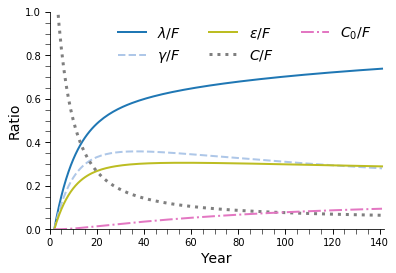

In [287]:
times = np.arange( 1, 142, 1 )

mean_T2 = np.ma.masked_where( mean_T2 > 20., mean_T2 ) #Take out places where it blows up
ratio = np.zeros( ( t, v ) )
for h in range( t ):
    for k in range( v ):
        ratio[h, k] = np.std( mean_T2[k, :, h] ) 

        
cs = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(cs)):    
    r, g, b = cs[i]    
    cs[i] = (r / 255., g / 255., b / 255.)    

ax = plt.subplot(1, 1, 1)

plt.plot( times[:], ratio[:, 1] / ratio[:, 0], color = cs[0], linewidth = 2. )
plt.plot( times[:], ratio[:, 2] / ratio[:, 0], '--', color = cs[1], linewidth = 2. )
plt.plot( times[:], ratio[:, 3] / ratio[:, 0], color = cs[16], linewidth = 2. )
plt.plot( times[:], ratio[:, 4] / ratio[:, 0], ':', color = cs[14], linewidth = 3. )
plt.plot( times[:], ratio[:, 5] / ratio[:, 0], '-.', color = cs[12], linewidth = 2 )

plt.legend(["$\lambda / F$", "$\gamma / F$", "$\epsilon / F$", "$C / F$", "$C_0 / F$"], fontsize = 14, frameon = False, loc = "upper right", ncol = 3 )

plt.ylim([0., 1.0])
plt.ylabel("Ratio", fontsize = 14)

plt.xlim([0., 142])
plt.xlabel("Year", fontsize = 14)

#plt.axhline( y = 1., color = 'k', linestyle = '--' )

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(.2)
minorLocator = MultipleLocator(.05)

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(20)
minorLocator = MultipleLocator(5)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig("time_scale_uncertainty.png" )
plt.show()



# Tuning example

In [288]:
import scipy.signal as sst

def butter_lowpass( cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sst.butter(order, normal_cutoff, btype='low')
    return b, a

def butter_low( data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    y = sst.lfilter(b, a, data)
    return y

In [289]:
#Load GMST
l = 168
f = open("historical_data/HADCRUT_data.dat", "r")
had_mean = np.zeros( l )
for i in range( l ):
    next = f.readline()
    had_mean[i] = float( next[6:14] )

f.close()

had_mean = butter_low( had_mean, 1. / 4., 1., 3. ) #Smooth annual mean_data

#Load CO2 concentrations
l = 700
year = np.zeros( l )
rcp = np.zeros( l )
f = open( "historical_data/RCP45_MIDYEAR_CONCENTRATIONS.DAT", 'r' )
for i in range( l ):
    next = f.readline()
    year[i] =  float(next[:10])
    rcp[ i] =  float(next[16:30])
rcp = rcp[135:240]
f.close()

#Load forcing estimate
l = 240
year = np.zeros( l )
forc = np.zeros( l )
f = open( "historical_data/20THCENTURY_MIDYEAR_RADFORCING.DAT", 'r' )
for i in range( l ):
    next = f.readline()
    year[i] =  float(next[:10])
    forc[ i] =  float(next[75:90])

forc = forc[135:]
year = year[135:]

In [321]:
def forcing2( co2, f, ico2 ):
    #Convert CO2 value to forcing
    return np.log( co2 / ico2 ) * f 

nf = (forc[104] - forc[0]) / np.log(rcp[104] / rcp[0]) #Scale CO2 forcing for net historical forcing
std_1 = var_std[0] * nf / var_mean[0] #Scale standard deviation
forc_h = forc[0] + forcing2( rcp, nf + std_1 , rcp[0] )
forc_l = forc[0] + forcing2( rcp, nf - std_1 , rcp[0] )


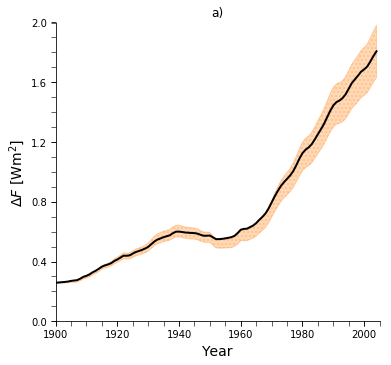

In [322]:
cs = [(31 / 255., 119 / 255., 180 / 255.), (44. / 255., 160 / 255., 44 / 255.), (214 / 255., 39 / 255., 40 / 255.), (255 / 255., 127 / 255., 14 / 255.) ]

fig = plt.figure( figsize = (15, 5) )
plt.subplots_adjust(left = 0.2, right = 0.95, bottom = 0.12, top = 0.95, wspace = 0.5)


ax = plt.subplot(1, 2, 1)
plt.title( "a)" )

diff = forc - forcing2( rcp, var_mean[0] , rcp[0] ) 

plt.plot( year, forc, 'k', linewidth = 2. )
ax.fill_between(year, forc_l, forc_h, color=cs[3], hatch="...",edgecolor=cs[3], zorder = 2, alpha = 0.3)

plt.ylim([0., 2.])
plt.ylabel("$\Delta F$ [Wm$^{2}$]", fontsize = 14)

plt.xlim([1900., 2005])
plt.xlabel("Year", fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(0.4)
minorLocator = MultipleLocator(0.1)

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(20)
minorLocator = MultipleLocator(5)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


In [340]:
nf = 20
t = 105
nforc = np.zeros( ( 20, t))

nforc[:] = np.linspace( forc_l, forc_h, nf )

ran_lam = np.zeros( nf )

for k in range( nf ):
    lam_est = np.arange(0.1, 2.01, 0.01 )
    l = len( lam_est )
    ts = np.zeros( ( l, t ) )

    for j in range( l ):
        T_1 = np.zeros( t )
        T_2 = np.zeros( t )

        for i in range( 1, t ):
            T_1[i] = T_1[i - 1] + 1. / var_mean[4] * ( nforc[k, i - 1] - lam_est[j] * T_1[i - 1] - var_mean[2] * var_mean[3] * (T_1[i - 1] - T_2[i - 1]) )
            T_2[i] = T_2[i - 1] + 1. / var_mean[5] * ( var_mean[2] * (T_1[i - 1] - T_2[i - 1]) )
        ts[j] = T_1

    rms = np.zeros( l )
    for i in range( l ):
        #Subtract mean value as comparing with anomalous GMST relative to mid-century mean
        #N.B the final slope is sensitive to this value
        rms[i] = np.sqrt( np.sum( ( ts[i] - had_mean[50:155] - 0.55 ) ** 2 ) )
    
    for i in range( l ):
        if rms[i] == min( rms ):
            a = i
    ran_lam[k] = lam_est[a]


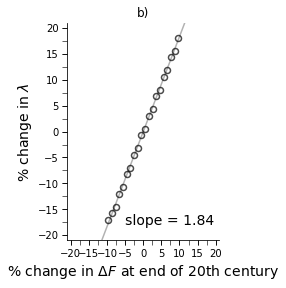

In [341]:
def lin_regression(var1, var2):
    """
    Regresses var1 onto var2
    Returns: slope, intercept, r_value, p_value, std_err
    """
    #print "Linear regression"
    return ss.linregress(var1, var2)

ax = plt.subplot( 1, 2, 2)
plt.title( "b)" )

forc_range = (nforc[:, t - 1] - np.mean(nforc[:, t - 1]) ) / np.mean(nforc[:, t - 1])
slope, inter = lin_regression(forc_range, (ran_lam[:] - np.mean(ran_lam[:]) ) / np.mean(ran_lam[:]) )[:2]

x = np.linspace( -1., 1., 10 )

plt.plot( x * 100., inter + slope * x * 100., color = 'k', linewidth = 1.5, alpha = 0.3 )
plt.plot( forc_range * 100., (ran_lam[:] - np.mean(ran_lam[:]) ) / np.mean(ran_lam[:]) * 100., 'o', markerfacecolor = 'None', markersize = 6., markeredgecolor = 'k', alpha = 0.7, markeredgewidth = 1.5)#markerfacecolor = 'None', markeredgecolor = 'k', markersize = 8. )


plt.text( -5, -18, r"slope = %1.2f" % slope, fontsize = 14 )


plt.ylim([-21, 21])
plt.xlim([-21, 21])

plt.ylabel("% change in $\lambda$", fontsize = 14)
plt.xlabel("% change in $\Delta F$ at end of 20th century", fontsize = 14)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

ax.tick_params(length = 5, which = 'both')

majorLocator = MultipleLocator(5.)
minorLocator = MultipleLocator(2.5)

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig("brute_search_result.png")
plt.show()

